# intall kaggle

In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kukuroo3/mosquito-indicator-in-seoul-korea

  0% 0.00/13.7k [00:00<?, ?B/s]
100% 13.7k/13.7k [00:00<00:00, 8.54MB/s]


In [ ]:
! unzip mosquito-indicator-in-seoul-korea

Archive:  mosquito-indicator-in-seoul-korea.zip
  inflating: mosquito_Indicator.csv  


# Import LIB

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

# Review Data

In [ ]:
data_train = pd.read_csv('/content/mosquito_Indicator.csv')
data_train.tail()

,date,mosquito_Indicator,rain(mm),mean_T(℃),min_T(℃),max_T(℃)
1337,2019-12-27,5.5,0.0,-1.7,-4.6,2.6
1338,2019-12-28,5.5,0.0,1.1,-3.6,6.1
1339,2019-12-29,5.5,1.4,3.8,1.1,6.2
1340,2019-12-30,5.5,0.4,2.7,-5.7,6.8
1341,2019-12-31,5.5,0.0,-7.9,-10.9,-4.5


In [ ]:
data_train.isnull().sum()

date                  0
mosquito_Indicator    0
rain(mm)              0
mean_T(℃)             0
min_T(℃)              0
max_T(℃)              0
dtype: int64

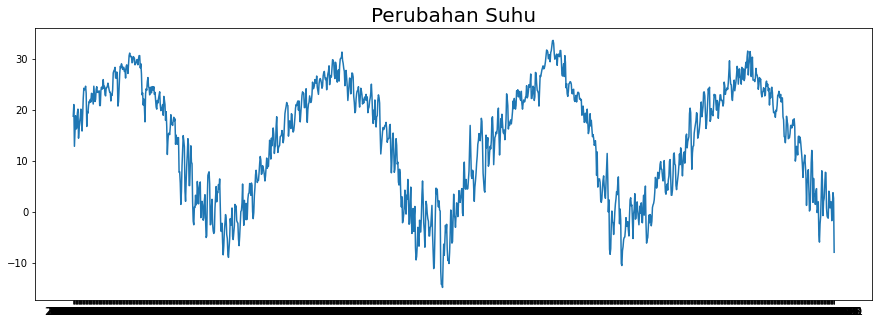

In [ ]:
dates = data_train['date'].values
temp  = data_train['mean_T(℃)'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Perubahan Suhu',
          fontsize=20);

# Pre-Processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(temp.reshape(1, -1))

MinMaxScaler()

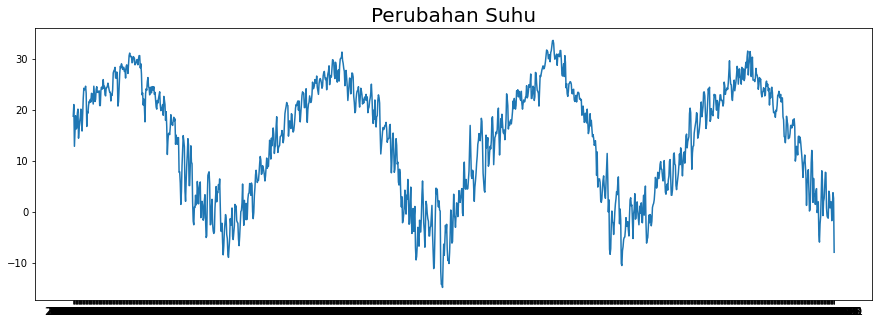

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Perubahan Suhu',
          fontsize=20);

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit(temp.reshape(1, -1))

StandardScaler()

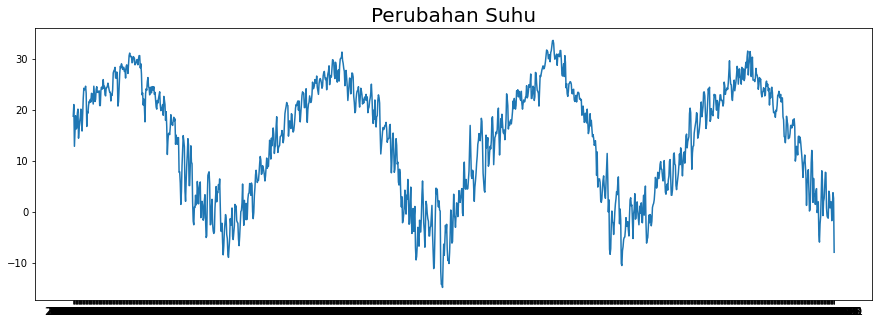

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Perubahan Suhu',
          fontsize=20);

In [ ]:
mae_treshold = (temp.max() -temp.min())*(10/100)
mae_treshold

4.8500000000000005

# Masuk ke ML

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(temp, test_size=0.2, shuffle=False)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(train, window_size=100, batch_size=32, shuffle_buffer=100)

In [ ]:
# Model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dense(70, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
# callbacks
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < mae_treshold):
      self.model.stop_training = True
      print("\n MAE sudah mencapai mae_treshold")

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 9s 108ms/step - loss: 13.2991 - mae: 13.7905
Epoch 2/100
31/31 [==============================] - 3s 106ms/step - loss: 13.2469 - mae: 13.7384
Epoch 3/100
31/31 [==============================] - 3s 106ms/step - loss: 13.2064 - mae: 13.6981
Epoch 4/100
31/31 [==============================] - 3s 105ms/step - loss: 13.1774 - mae: 13.6691
Epoch 5/100
31/31 [==============================] - 3s 107ms/step - loss: 13.1434 - mae: 13.6352
Epoch 6/100
31/31 [==============================] - 3s 106ms/step - loss: 13.1085 - mae: 13.6003
Epoch 7/100
31/31 [==============================] - 3s 107ms/step - loss: 13.0722 - mae: 13.5640
Epoch 8/100
31/31 [==============================] - 3s 108ms/step - loss: 13.0333 - mae: 13.5252
Epoch 9/100
31/31 [==============================] - 3s 107ms/step - loss: 12.9927 - mae: 13.4847
Epoch 10/100
31/31 [==============================] - 3s 106ms/step - loss: 12.9482 - mae: 13.4402
Epoch 11/100
31/31 